In [1]:
import torch
import PIL
import os
import cv2
from scipy import ndimage
import numpy as np
from PIL import Image
import torchvision
from torchvision import transforms
from src.efficientunet import *
import random
import matplotlib.pyplot as plt
from src.dataset import  RetinalDataset
from src.model import get_torchvision_model
import src.segmentation_models_pytorch as smp
from scipy.ndimage.morphology import binary_dilation, binary_erosion

In [2]:
model = get_torchvision_model("Se_resnext50", True, 1, "focal")

In [3]:
state_dict = torch.load("models/success_model/Se_resnext50_model.pth",  map_location=torch.device('cpu'))
state_dict = state_dict["state"]
model.load_state_dict(state_dict)

<All keys matched successfully>

# Transformation

In [4]:
def train_transformation(image, mask, size):
    tensor_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomApply([
            transforms.RandomAffine(degrees=[-45, 45], translate=[0.15, 0.15], scale=[1.0, 1.2]),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5)], p=0.85),
        transforms.ToTensor()
    ])
    mask_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomApply([
            transforms.RandomAffine(degrees=[-45, 45], translate=[0.15, 0.15], scale=[1.0, 1.2]),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5)], p=0.85),
        transforms.ToTensor()
    ])
    
    #apply transform to image and grouth truth:
    seed = np.random.randint(2147483647) # make a seed with numpy generator 
    random.seed(seed)
    image = tensor_transform(image)
    random.seed(seed) # apply this seed to target tranfsorms
    mask = mask_transform(mask)
#     mask = torch.ByteTensor(np.array(mask))

    return image, mask
def inference_transformation(image, mask, size):
    """ Transform image for validation

    Parameters
    ----------
    image: PIL.Image
        image to transform
    size: int
        size to scale

    Returns
    -------

    """
    tensor_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()
    ])
    mask_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()
    ])
    
    #apply transform to image and grouth truth:
    image = tensor_transform(image)
    mask = mask_transform(mask)
#     mask = torch.ByteTensor(np.array(mask))

    return image, mask

In [5]:
class FAZ_Preprocess:
    def __init__(self,image_name, sigma, spacing, tau):
        super(FAZ_Preprocess, self).__init__()
        image = Image.open(image_name).convert("RGB")
        image = np.array(image)
        image = 255-image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        self.size = image.shape
        thr = np.percentile(image[(image > 0)], 1)*0.9
        image[(image <= thr)] = thr
        image = image - np.min(image)
        image = image / np.max(image)
        
        self.image =image
        self.sigma = sigma
        self.spacing = spacing
        self.tau = tau
    
    def gaussian(self, image, sigma):
        siz = sigma * 6
        temp = round(siz/self.spacing/2)
        #processing x-axis
        x = [i for i in range(-temp, temp+1)]
        x = np.array(x)
        H = np.exp(-(x**2 / (2*((sigma/self.spacing)**2) )))
        H = H / np.sum(H)
        Hx = H.reshape(len(H),1)
        I = ndimage.filters.convolve(image, Hx, mode='nearest')

        #processing y-axis
        temp = round(siz/self.spacing/2)
        x = [i for i in range(-temp, temp+1)]
        x = np.array(x)
        H = np.exp(-(x**2 / (2*((sigma/self.spacing)**2) )))
        H = H / np.sum(H[:])
        Hy = H.reshape(1,len(H))
        I = ndimage.filters.convolve(I, Hy, mode= 'nearest')
        return I
    
    def gradient2(self, F, option):
        k = self.size[0]
        l = self.size[1]
        D = np.zeros(F.shape)
        if option == "x":
            D[0,:] = F[1,:] - F[0,:]
            D[k-1, :] = F[k-1,:]-F[k-2,:]

            #take center differences on interior points
            D[1:k-2, :] = (F[2:k-1,:]-F[0:k-3,:])/2
        else:
            D[:,0] = F[:,1]-F[:,0]
            D[:,l-1] = F[:,l-1]-F[:, l-2]
            D[:,1:l-2] = (F[:,2:l-1] - F[:,0:l-3])/2
        return D
    
    def Hessian2d(self, image, sigma):
        image = self.gaussian(image, sigma)
    #     image = ndimage.gaussian_filter(image, sigma, mode = 'nearest')
        Dy = self.gradient2(image,"y") 
        Dyy = self.gradient2(Dy, "y")

        Dx = self.gradient2(image, "x")
        Dxx = self.gradient2(Dx, "x")
        Dxy = self.gradient2(Dx, 'y')
        return Dxx, Dyy, Dxy
    
    def eigvalOfhessian2d(self, Dxx, Dyy, Dxy):
        tmp = np.sqrt((Dxx-Dyy)**2 + 4*(Dxy**2))
        #compute eigenvectors of J, v1 and v2
        mu1 = 0.5 * (Dxx+Dyy + tmp)
        mu2 = 0.5 * (Dxx+Dyy - tmp)
        #Sort eigen values by absolute value abs(Lambda1) < abs(Lambda2)
        indices = (np.absolute(mu1) > np.absolute(mu2))
        Lambda1 = mu1
        Lambda1[indices] = mu2[indices]
        
        Lambda2 = mu2
        Lambda2[indices] = mu1[indices]
        return Lambda1, Lambda2
    
    def imageEigenvalues(self, I, sigma):
        hxx, hyy, hxy = self.Hessian2d(I, sigma)
        # hxx, hyy, hxy = self.Hessian2d(I, sigma)
        c = sigma ** 2 
        hxx = -c* hxx
        # hxx = hxx.flatten()
        hyy = -c* hyy
        # hyy = hyy.flatten()
        hxy = -c* hxy
        # hxy = hxy.flatten()

        # # reduce computation by computing vesselness only where needed
        B1 = -(hxx+hyy)
        B2 = hxx * hyy - hxy **2
        T = np.ones(B1.shape)
        T[(B1 < 0)]= 0
        T[(B1==0) & (B2==0)]= 0
        T = T.flatten()
        indeces = np.where(T == 1)[0]
        hxx = hxx.flatten()
        hyy = hyy.flatten()
        hxy = hxy.flatten()
        hxx = hxx[indeces]
        hyy = hyy[indeces]
        hxy = hxy[indeces]
    #     lambda1i, lambda2i = hessian_matrix_eigvals([hxx, hyy, hxy])
        lambda1i, lambda2i = self.eigvalOfhessian2d(hxx, hyy, hxy)
        lambda1 = np.zeros(self.size[0] * self.size[1],)
        lambda2 = np.zeros(self.size[0] * self.size[1],)

        lambda1[indeces] = lambda1i
        lambda2[indeces] = lambda2i

        #removing noise
        lambda1[(np.isinf(lambda1))] = 0
        lambda2[(np.isinf(lambda2))] = 0

        lambda1[(np.absolute(lambda1) < 1e-4)]=0
        lambda1 = lambda1.reshape(self.size)
        
        lambda2[(np.absolute(lambda2) < 1e-4)]=0
        lambda2 = lambda2.reshape(self.size)
        return lambda1, lambda2
    
    def vesselness2d(self):
        for j in range(len(self.sigma)):
            lambda1, lambda2 = self.imageEigenvalues(self.image, self.sigma[j])
            lambda3 = lambda2.copy()
            new_tau = self.tau * np.min(lambda3) 
            lambda3[(lambda3 <0) & (lambda3>= new_tau)] = new_tau
            different = lambda3 - lambda2
            response = ((np.absolute(lambda2)**2) * np.absolute(different)) *27 / ((2*np.absolute(lambda2)+np.absolute(different))**3)
            response[(lambda2 < lambda3/2 )] = 1
            response[(lambda2 >= 0)] = 0

            response[np.where(np.isinf(response))[0]] = 0
            if j == 0 :
                vesselness = response
            else:
                vesselness = np.maximum(vesselness, response)
    #     vesselness = vesselness / np.max(vesselness)
        vesselness[(vesselness < 1e-2)] = 0
#         vesselness = vesselness.reshape(self.size)
        return vesselness

# Level-set 

In [6]:
import numpy as np
import scipy.ndimage.filters as filters


def del2(M):
    dx = 1
    dy = 1
    rows, cols = M.shape
    dx = dx * np.ones((1, cols - 1))
    dy = dy * np.ones((rows - 1, 1))

    mr, mc = M.shape
    D = np.zeros((mr, mc))

    if (mr >= 3):
        ## x direction
        ## left and right boundary
        D[:, 0] = (M[:, 0] - 2 * M[:, 1] + M[:, 2]) / (dx[:, 0] * dx[:, 1])
        D[:, mc - 1] = (M[:, mc - 3] - 2 * M[:, mc - 2] + M[:, mc - 1]) \
                       / (dx[:, mc - 3] * dx[:, mc - 2])

        ## interior points
        tmp1 = D[:, 1:mc - 1]
        tmp2 = (M[:, 2:mc] - 2 * M[:, 1:mc - 1] + M[:, 0:mc - 2])
        tmp3 = np.kron(dx[:, 0:mc - 2] * dx[:, 1:mc - 1], np.ones((mr, 1)))
        D[:, 1:mc - 1] = tmp1 + tmp2 / tmp3

    if (mr >= 3):
        ## y direction
        ## top and bottom boundary
        D[0, :] = D[0, :] + \
                  (M[0, :] - 2 * M[1, :] + M[2, :]) / (dy[0, :] * dy[1, :])

        D[mr - 1, :] = D[mr - 1, :] \
                       + (M[mr - 3, :] - 2 * M[mr - 2, :] + M[mr - 1, :]) \
                         / (dy[mr - 3, :] * dx[:, mr - 2])

        ## interior points
        tmp1 = D[1:mr - 1, :]
        tmp2 = (M[2:mr, :] - 2 * M[1:mr - 1, :] + M[0:mr - 2, :])
        tmp3 = np.kron(dy[0:mr - 2, :] * dy[1:mr - 1, :], np.ones((1, mc)))
        D[1:mr - 1, :] = tmp1 + tmp2 / tmp3

    return D / 4


def drlse_edge(phi_0, g, lmda, mu, alfa, epsilon, timestep, iters, potentialFunction):  # Updated Level Set Function
    """
    :param phi_0: level set function to be updated by level set evolution
    :param g: edge indicator function
    :param lmda: weight of the weighted length term
    :param mu: weight of distance regularization term
    :param alfa: weight of the weighted area term
    :param epsilon: width of Dirac Delta function
    :param timestep: time step
    :param iters: number of iterations
    :param potentialFunction: choice of potential function in distance regularization term.
%              As mentioned in the above paper, two choices are provided: potentialFunction='single-well' or
%              potentialFunction='double-well', which correspond to the potential functions p1 (single-well)
%              and p2 (double-well), respectively.
    """
    phi = phi_0.copy()
    [vy, vx] = np.gradient(g)
    for k in range(iters):
        phi = NeumannBoundCond(phi)
        [phi_y, phi_x] = np.gradient(phi)
        s = np.sqrt(np.square(phi_x) + np.square(phi_y))
        smallNumber = 1e-10
        Nx = phi_x / (s + smallNumber)  # add a small positive number to avoid division by zero
        Ny = phi_y / (s + smallNumber)
        curvature = div(Nx, Ny)
        if potentialFunction == 'single-well':
            distRegTerm = filters.laplace(phi, mode='wrap') - curvature  # compute distance regularization term in equation (13) with the single-well potential p1.
        elif potentialFunction == 'double-well':
            distRegTerm = distReg_p2(phi)  # compute the distance regularization term in eqaution (13) with the double-well potential p2.
        else:
            print('Error: Wrong choice of potential function. Please input the string "single-well" or "double-well" in the drlse_edge function.')
        diracPhi = Dirac(phi, epsilon)
        areaTerm = diracPhi * g  # balloon/pressure force
        edgeTerm = diracPhi * (vx * Nx + vy * Ny) + diracPhi * g * curvature
        phi = phi + timestep * (mu * distRegTerm + lmda * edgeTerm + alfa * areaTerm)
    return phi


def distReg_p2(phi):
    """
        compute the distance regularization term with the double-well potential p2 in equation (16)
    """
    [phi_y, phi_x] = np.gradient(phi)
    s = np.sqrt(np.square(phi_x) + np.square(phi_y))
    a = (s >= 0) & (s <= 1)
    b = (s > 1)
    ps = a * np.sin(2 * np.pi * s) / (2 * np.pi) + b * (s - 1)  # compute first order derivative of the double-well potential p2 in equation (16)
    dps = ((ps != 0) * ps + (ps == 0)) / ((s != 0) * s + (s == 0))  # compute d_p(s)=p'(s)/s in equation (10). As s-->0, we have d_p(s)-->1 according to equation (18)
    return div(dps * phi_x - phi_x, dps * phi_y - phi_y) + filters.laplace(phi, mode='wrap')


def div(nx, ny):
    [junk, nxx] = np.gradient(nx)
    [nyy, junk] = np.gradient(ny)
    return nxx + nyy


def Dirac(x, sigma):
    f = (1 / 2 / sigma) * (1 + np.cos(np.pi * x / sigma))
    b = (x <= sigma) & (x >= -sigma)
    return f * b


def NeumannBoundCond(f):
    """
        Make a function satisfy Neumann boundary condition
    """
    [ny, nx] = f.shape
    g = f.copy()

    g[0, 0] = g[2, 2]
    g[0, nx-1] = g[2, nx-3]
    g[ny-1, 0] = g[ny-3, 2]
    g[ny-1, nx-1] = g[ny-3, nx-3]

    g[0, 1:-1] = g[2, 1:-1]
    g[ny-1, 1:-1] = g[ny-3, 1:-1]

    g[1:-1, 0] = g[1:-1, 2]
    g[1:-1, nx-1] = g[1:-1, nx-3]

    return g

In [10]:
def scoring(gt, pred):
        gt = gt.to("cpu").numpy()
        intersection = np.logical_and(pred, gt).sum()
        union = np.logical_or(pred, gt).sum()
        
        # calculate false positive
        false_pos = np.sum(pred)- intersection
        FP = false_pos / np.sum(pred)
        FP = round(FP, 2)
        #calculate false negative
        false_neg = np.sum(gt) - intersection
        FN = false_neg / np.sum(gt)
        FN = round(FN, 2)
        
        #calculate IoU
        if union != 0:
            iou = intersection / union
            iou = round(iou, 2)
        return iou, FP, FN

def visualization(model, raw_folder, mask_folder, number_image, size):
    image_name = [name for name in os.listdir(raw_folder)]
    try:
        image_name = image_name[0:number_image]
        rows, columns = number_image, 3
    except:
        rows, columns = len(image_name), 3
    
    
    fig=plt.figure(figsize=(30, 10 * number_image))
    # Transformation:
    tensor_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()
    ])
    for idx, name in enumerate(image_name): 
        
        #Loading image and mask
        raw_image = FAZ_Preprocess(os.path.join(raw_folder, name),[0.5,1, 1.5, 2, 2.5],1, 2)
        raw_image = raw_image.vesselness2d()
        image = Image.fromarray(raw_image.astype(np.float32)*255).convert("RGB")
        image = tensor_transform(image)
        try:
            labels = Image.open(os.path.join(mask_folder, name))
            labels = tensor_transform(labels)
        except:
            mask_name  = name.replace("tif","png")
            labels = Image.open(os.path.join(mask_folder, mask_name))
            labels = tensor_transform(labels)
        #Prediction model:
        model.eval()
        mask = image.unsqueeze(0)
        mask = model(mask)
        mask = (mask.to("cpu").detach().numpy() > 0.6)*1
        mask = mask.reshape((size,size))
        
        #prepare image for visualization
        image = image.permute(1,2,0).numpy()
        image =  cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        levelset_img = image.copy()
        levelset_img = levelset_img * 255
        levelset_img = levelset_img.astype(np.uint8)
        levelset_img = levelset_img.astype(np.float32)
        phi = mask.copy()
        
        #erosion the output mask
        kernel1 = np.array([[0, 0, 1, 0, 0],
                   [0, 1, 1, 1, 0],
                   [1, 1, 1, 1, 1],
                   [0, 1, 1, 1, 0],
                   [0, 0, 1, 0, 0]])   
        kernel2 = np.ones((5,5))
        new_phi = binary_erosion(phi, kernel1, iterations = 3)
        phi = 1-phi
        new_phi = 1-new_phi
        
        ######### Hyper parameter for 
        timestep = 1        # time step
        mu = 0.2/timestep   # coefficient of the distance regularization term R(phi)
        iter_inner = 5
        iter_outer = 24
        lmda = 5            # coefficient of the weighted length term L(phi)
        alfa = -3           # coefficient of the weighted area term A(phi)
        epsilon = 1.5     # parameter that specifies the width of the DiracDel
        sigma = 0.8     # scale parameter in Gaussian kernel
        img_smooth = filters.gaussian_filter(levelset_img, sigma)    # smooth image by Gaussian convolution
        [Iy, Ix] = np.gradient(img_smooth)
        f = np.square(Ix) + np.square(Iy)
        g = 1 / (1+f)    # edge indicator function.
        potentialFunction = 'double-well'
        
        # start level set evolution
        for n in range(iter_outer):
            phi = drlse_edge(phi, g, lmda, mu, alfa, epsilon, timestep, iter_inner, potentialFunction)
        iter_refine = 10
        phi = drlse_edge(phi, g, lmda, mu, alfa, epsilon, timestep, iter_refine, potentialFunction)
        
        #preprocessing part with erosion
        for n in range(iter_outer):
            new_phi = drlse_edge(new_phi, g, lmda, mu, alfa, epsilon, timestep, iter_inner, potentialFunction)
        iter_refine = 10
        new_phi = drlse_edge(new_phi, g, lmda, mu, alfa, epsilon, timestep, iter_refine, potentialFunction)
        new_phi = new_phi -np.min(new_phi)
        new_phi = new_phi / np.max(new_phi)
        new_phi = 1-new_phi
        new_phi = (new_phi > 0.6) * 1.0
        kernel2 = np.ones((5,5))
#         kernel1= np.ones((3,3))
#         new_phi = binary_erosion(new_phi, kernel2, iterations = 2)
#         new_phi = binary_dilation(new_phi, kernel2, iterations=1)
        
        #preprocessing mask output
        phi = phi -np.min(phi)
        phi = phi / np.max(phi)
        phi = 1-phi
        phi = (phi > 0.6) * 1.0
        
        # dilation and erosion to remove noise
        kernel = np.array([[0, 0, 1, 0, 0],
                           [0, 1, 1, 1, 0],
                           [1, 1, 1, 1, 1],
                           [0, 1, 1, 1, 0],
                           [0, 0, 1, 0, 0]])  
        kernel2 = np.ones((5,5))
#         phi = binary_erosion(phi, kernel2, iterations = 2)
#         phi = binary_dilation(phi, kernel, iterations=1)
       
######################################### Visualization #############################################    
         #visualize the Levelset output:
        iou, FP, FN = scoring(labels, mask)
        fig.add_subplot(rows, columns, 3*idx+1 )
        plt.title(f'Just only Unet: IoU: {iou} FP: {FP} FN: {FN}')
#         plt.title(f'Levelset + Unet technique: IoU: {iou} FP: {FP} FN: {FN}')
        plt.imshow(image)
        plt.imshow(mask, cmap='gray', alpha=0.15)
        
        #visualize the Levelset output:
        iou, FP, FN = scoring(labels, phi)
        fig.add_subplot(rows, columns, 3*idx +2)
        plt.title(f'Unet + Levelset: IoU: {iou} FP: {FP} FN: {FN}')
#         plt.title(f'Levelset + Unet technique: IoU: {iou} FP: {FP} FN: {FN}')
        plt.imshow(image)
        plt.imshow(phi, cmap='gray', alpha=0.15)
        
        
        #Visualize the Unet output:
        iou, FP, FN = scoring(labels, new_phi)
        fig.add_subplot(rows, columns, 3*idx +3)
        plt.title(f'Unet + Erosion + Levelset: IoU: {iou} FP: {FP} FN: {FN}')
#         plt.title(f'Unet technique: IoU: {iou} FP: {FP} FN: {FN}')
        plt.imshow(image)
        plt.imshow(new_phi, cmap='gray', alpha=0.15)

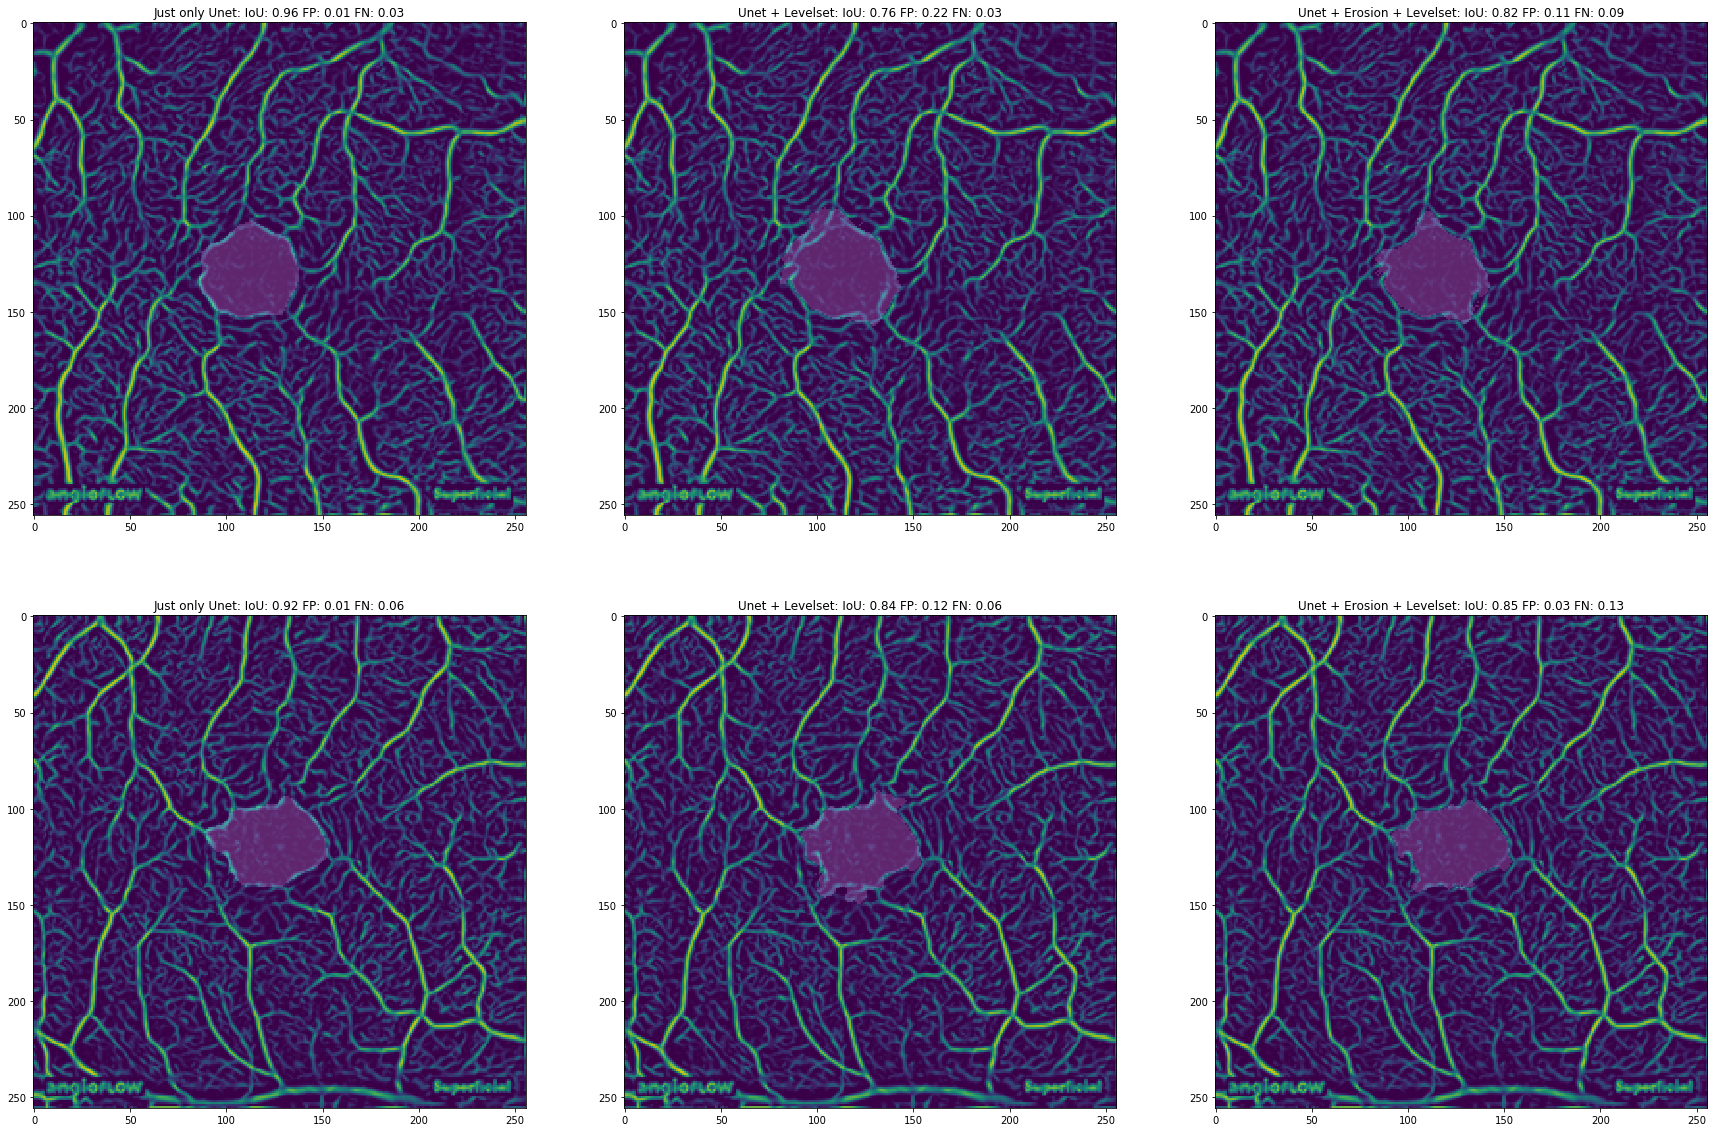

In [11]:
visualization(model, "../dataset/test/raw", "../dataset/test/mask", 2, 256)